In [1]:
import torch
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from time import time

New updates, we try 2 classes in model

In [2]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# 0. Constants

In [3]:
img_size = (256, 256)

batch_size = 4
valid_batch_size = 2
epochs = 25
n_print = 500
lr = 0.001

workers = 4
isCuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True
print("Device: {}".format(device))

model_saved_dir = "models/Unet3+"
if os.path.exists(model_saved_dir) == False:
    os.mkdir(model_saved_dir)

Device: cuda:0


# 1. Data

In [4]:
from src.scripts.DataLoaders import LeftCamusDataset, get_image_filepaths, ImgForPlot  # HeartLoader
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader

In [6]:
# Write transform for image
data_transform = transforms.Compose([
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    transforms.Resize(size=img_size),
])

In [7]:
train_path = "data/train/echoLA/training"
test_path = "data/train/echoLA/testing"

img_train_paths = get_image_filepaths(os.path.join(train_path, "images"), img_format='.jpg')
img_test_paths = get_image_filepaths(os.path.join(test_path, "images"), img_format='.jpg')

msk_train_paths = get_image_filepaths(os.path.join(train_path, "masks"), img_format='.png')
msk_test_paths = get_image_filepaths(os.path.join(test_path, "masks"), img_format='.png')

len(img_train_paths), len(msk_test_paths)

(20997, 2235)

In [8]:
train_dataset = LeftCamusDataset(img_train_paths, msk_train_paths, transforms=data_transform)
test_dataset = LeftCamusDataset(img_test_paths, msk_test_paths, transforms=data_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 2. Model

In [9]:
# from src.scripts.models.Unet3plus import unet3plus
from src.scripts.models.U3plus import unet3plus
from torchvision.transforms import v2

In [10]:
model_name = 'Unet3plus'
loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"

with open(loss_path, 'rb') as f:
  losses = pickle.load(f)

model = unet3plus(num_classes=2).cuda()
# model.load_state_dict(torch.load(model_path))

# 3. Train


nvidia-settings -a GPUFanControlState=1 -a GPUTargetFanSpeed=90


In [11]:
# import numpy as np
# import matplotlib.pyplot as plt



# beta = 8
# def linear_cos(xx):
#     return beta * np.cos(xx) - (1/0.33 * xx)

# xx = np.arange(30)
# plt.plot(xx, (linear_cos(xx)*0.005) + 0.05)

# LR_START = 1e-5
# LR_MAX = 2e-3
# LR_RAMPUP_EPOCHS = 10
# LR_SUSTAIN_EPOCHS = 0
# LR_STEP_DECAY = 1 # 0.85
# ALPHA = 3

# def warmup_scheduler(epoch, lr):
#     if epoch < LR_RAMPUP_EPOCHS:
#         lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
#         # lr = 0.01
#     elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
#         lr = LR_MAX
#     else:
#         # lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//3)
#         # lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) // ALPHA)
#         lr = linear_cos(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) * LR_START + LR_MAX
#         lr = lr * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) // ALPHA)

#     return lr


# plt.plot(xx, [warmup_scheduler(x, 0.01) for x in xx])
# plt.show()

In [12]:
class FocalLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):
        
        # first compute binary cross-entropy
        BCE = torch.nn.functional.cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP) ** gamma * BCE

        return focal_loss
    
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
class FocalDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalDiceLoss, self).__init__()
        # 
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()

    def forward(self, inputs, targets):
        # ПОКА ОСТАВЛЮ ТАК
        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs) 
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        dice = self.dice_loss(inputs, targets)
        focal = self.focal_loss(inputs, targets, alpha=0.8, gamma=2)

        return dice + focal
    
class Dice(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs) 
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice

In [13]:
class FocalLoss_v2(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss_v2, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):
        
        # inputs = F.sigmoid(inputs) 
        # inputs = inputs.view(-1)
        # targets = targets.view(-1)
        # first compute binary cross-entropy
        # BCE = torch.nn.functional.cross_entropy(inputs, targets, reduction='mean')
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) # prevents nans when probability 0
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return focal_loss.mean()


In [14]:
from src.scripts.losses import IoULoss, DiceBCELoss, DiceLoss

# Losses
# IoU_loss = IoULoss()
# Dice =  DiceLoss()
Focal = FocalLoss_v2()
seg_loss = FocalDiceLoss() 
DBCE = DiceBCELoss()

# Metrics
# DICE = Dice()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
# Dice =  DiceLoss()
# Focal = FocalLoss_v2()

# indx = 0
# Dice(out[indx].to('cpu'), target.to('cpu')), Focal(out[indx].to('cpu'), target.to('cpu'))

In [16]:
import math


LR_START = 0.001
T_alpha = 8   # Time constant, чем меньше тем быстрее убывает
LOW = 0.0002

def update_lr(epoch):
  # Decrease lr every T epochs
  new_lr = (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW  # lr * math.pow(0.5, epoch // T)
  print('Learning Rate: %.6f' % new_lr)
  for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr

In [17]:
version = 1


if version:
  loss_path = F"{model_saved_dir}/{model_name}_loss_{version}.txt"
  best_model_path = F"{model_saved_dir}/{model_name}_best_{version}.pt"
  model_path = F"{model_saved_dir}/{model_name}_{version}.pt"
else: 
  loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
  best_model_path = F"{model_saved_dir}/{model_name}_best.pt"
  model_path = F"{model_saved_dir}/{model_name}.pt"

start_epoch = 0

if start_epoch == 0:
  losses = {'train': [], 'valid': []}
  best_loss = float("inf")
else:
  best_loss = min(losses['valid'])


for ep in range(start_epoch, epochs):
    update_lr(ep)
    step, loss_sum = 0, 0.
    timestamp = time()
    for batch_idx, (input, target) in enumerate(train_loader, 0):
        input = input.to(device)
        target = target.to(device)
        step += 1
        # Train Model
        model.train()
        optimizer.zero_grad()
        
        out = model(input)
        each_loss = [ DBCE(o, target) for o in out ]  
        loss = sum(each_loss)
        
        loss.backward()
        optimizer.step()

        # Append Loss
        losses['train'].append(loss.item())
        loss_sum += loss.item()

        if (batch_idx+1) % n_print == 0 or batch_idx == (len(train_loader)-1):
            print('[%2d/%2d][%4d/%4d] Train: %.4f (%ds)' % (ep+1, epochs, batch_idx+1, len(train_loader), loss_sum/step, time() - timestamp))
            step, loss_sum = 0, 0.
            timestamp = time()
      
    # Evaluate Model
    model.eval()
    step, loss_sum = 0, 0.
    timestamp = time()
    with torch.no_grad():
        for input, target in tqdm(test_loader):
            out = model(input.to(device))[-1]
            if out.ndim == 3:
                out = out.unsqueeze(1)
            
            loss_sum += DBCE(out, target.to(device)).item() * input.size(0)  # MAE(out, target.to(device)).item() * input.size(0)
            step += input.size(0)
      
        val_loss = loss_sum / step
        losses['valid'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    print('[%2d/%2d] Valid: %.4f (Best: %.4f) (%ds)' % (ep+1, epochs, val_loss, best_loss, time() - timestamp))

    torch.save(model.state_dict(), model_path)
    with open(loss_path, 'wb') as f:
        pickle.dump(losses, f)
    
    print("Saved model completely!")

Learning Rate: 0.001000
[ 1/25][ 500/10499] Train: 1.6065 (139s)
[ 1/25][1000/10499] Train: 1.0089 (135s)
[ 1/25][1500/10499] Train: 0.9129 (135s)
[ 1/25][2000/10499] Train: 0.8268 (134s)
[ 1/25][2500/10499] Train: 0.7839 (137s)
[ 1/25][3000/10499] Train: 0.7664 (140s)
[ 1/25][3500/10499] Train: 0.7105 (136s)
[ 1/25][4000/10499] Train: 0.7190 (133s)
[ 1/25][4500/10499] Train: 0.7193 (133s)
[ 1/25][5000/10499] Train: 0.6766 (133s)
[ 1/25][5500/10499] Train: 0.6504 (133s)
[ 1/25][6000/10499] Train: 0.6424 (133s)
[ 1/25][6500/10499] Train: 0.6472 (133s)
[ 1/25][7000/10499] Train: 0.6449 (133s)
[ 1/25][7500/10499] Train: 0.6384 (134s)
[ 1/25][8000/10499] Train: 0.6050 (132s)
[ 1/25][8500/10499] Train: 0.5900 (134s)
[ 1/25][9000/10499] Train: 0.5828 (135s)
[ 1/25][9500/10499] Train: 0.5867 (133s)
[ 1/25][10000/10499] Train: 0.5872 (133s)
[ 1/25][10499/10499] Train: 0.5605 (136s)


100%|██████████| 1118/1118 [00:59<00:00, 18.91it/s]


[ 1/25] Valid: 0.1241 (Best: 0.1241) (59s)
Saved model completely!
Learning Rate: 0.000906
[ 2/25][ 500/10499] Train: 0.5459 (131s)
[ 2/25][1000/10499] Train: 0.5239 (132s)
[ 2/25][1500/10499] Train: 0.5385 (131s)
[ 2/25][2000/10499] Train: 0.5247 (131s)
[ 2/25][2500/10499] Train: 0.5167 (130s)
[ 2/25][3000/10499] Train: 0.5162 (131s)
[ 2/25][3500/10499] Train: 0.5154 (130s)
[ 2/25][4000/10499] Train: 0.5070 (130s)
[ 2/25][4500/10499] Train: 0.5053 (132s)
[ 2/25][5000/10499] Train: 0.4922 (131s)
[ 2/25][5500/10499] Train: 0.4867 (130s)
[ 2/25][6000/10499] Train: 0.4846 (132s)
[ 2/25][6500/10499] Train: 0.4758 (129s)
[ 2/25][7000/10499] Train: 0.4785 (129s)
[ 2/25][7500/10499] Train: 0.4588 (130s)
[ 2/25][8000/10499] Train: 0.4756 (129s)
[ 2/25][8500/10499] Train: 0.4540 (129s)
[ 2/25][9000/10499] Train: 0.4543 (130s)
[ 2/25][9500/10499] Train: 0.4494 (132s)
[ 2/25][10000/10499] Train: 0.4448 (130s)
[ 2/25][10499/10499] Train: 0.4257 (130s)


100%|██████████| 1118/1118 [00:57<00:00, 19.60it/s]


[ 2/25] Valid: 0.1271 (Best: 0.1241) (57s)
Saved model completely!
Learning Rate: 0.000823
[ 3/25][ 500/10499] Train: 0.4147 (131s)
[ 3/25][1000/10499] Train: 0.4024 (131s)
[ 3/25][1500/10499] Train: 0.3919 (130s)
[ 3/25][2000/10499] Train: 0.3906 (131s)
[ 3/25][2500/10499] Train: 0.3808 (131s)
[ 3/25][3000/10499] Train: 0.3901 (131s)


KeyboardInterrupt: 

In [19]:
def prepare_input(img):
    # 
    if img.shape != (512, 512, 3):
        img = cv2.resize(img, (512, 512))

    img = img / 255
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    img = torch.from_numpy(img).cuda()

    return img

def prepare_output(pred):
    if len(pred) > 1:
        pred = pred[-1]
    if pred.ndim == 4:
        pred = pred[0]

    pred = pred.cpu().detach().numpy()
    pred = sigmoid(pred)
    return np.transpose(pred, (1, 2, 0))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Already numpy.array


ValueError: axes don't match array

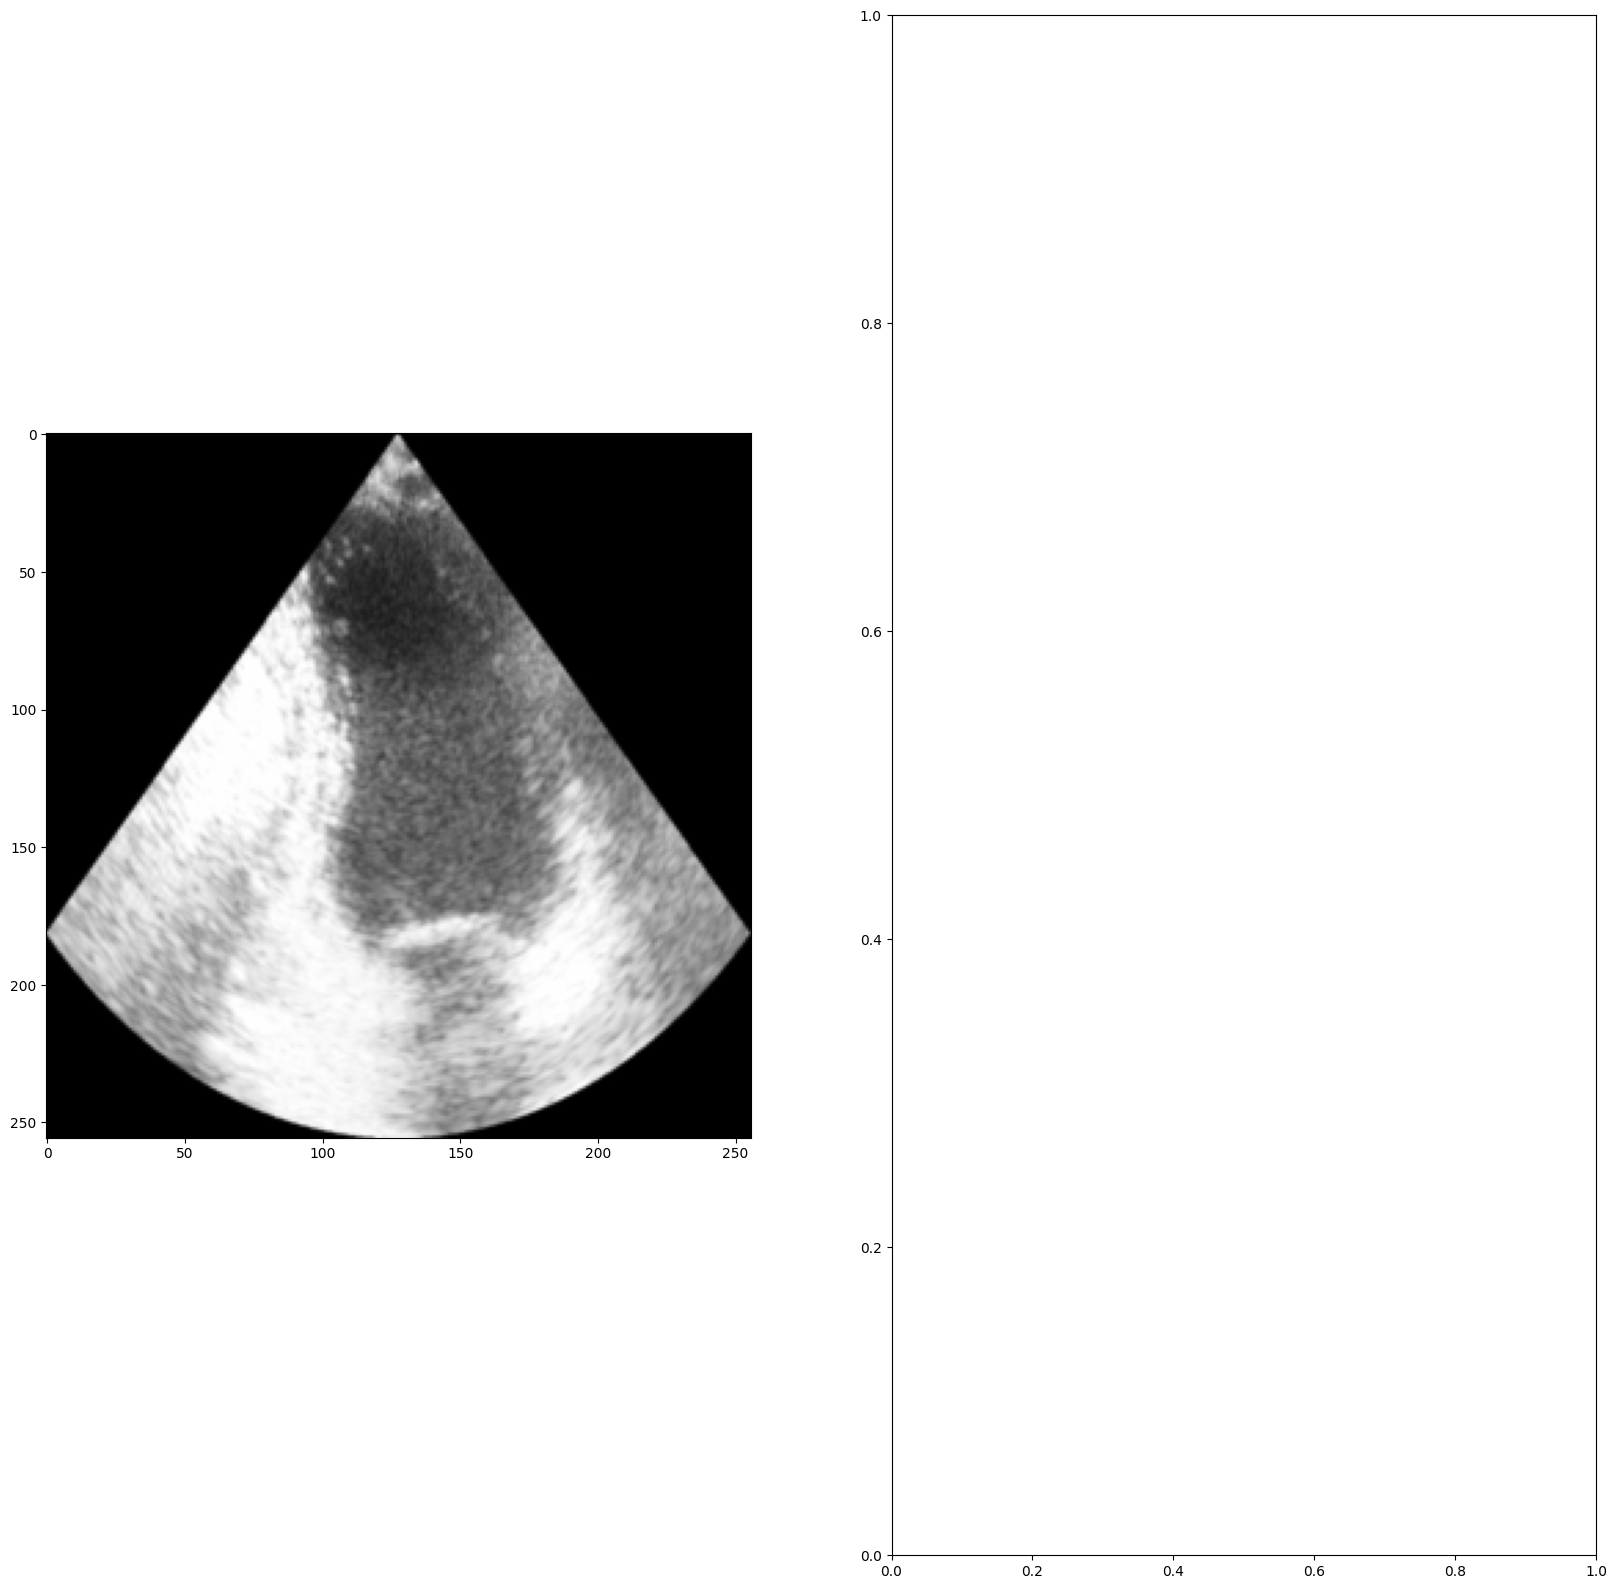

In [23]:
im, m = next(iter(test_dataset))
fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m)[:, :, 0], 'gray');

In [29]:
pred = model(im.unsqueeze(0).to(device))[-1]
pred = prepare_output(pred)
pred.shape

(256, 256, 2)

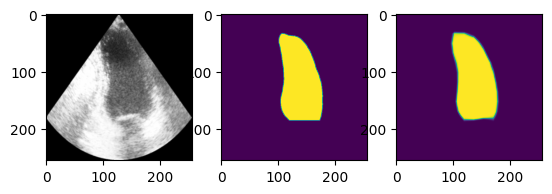

In [34]:
plt.subplot(131)
plt.imshow(ImgForPlot(im));
# plt.imshow(im.transpose((1, 2, 0)))
plt.subplot(132)
plt.imshow(ImgForPlot(m)[:, :, 0]);
plt.subplot(133)
plt.imshow(pred[:, :, 0])

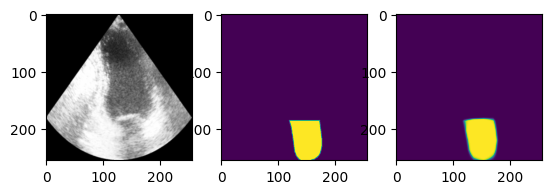

In [35]:
plt.subplot(131)
plt.imshow(ImgForPlot(im));
plt.subplot(132)
plt.imshow(ImgForPlot(m)[:, :, 1]);
plt.subplot(133)
plt.imshow(pred[:, :, 1])